# Histogrammes des Orientations du Gradient

In [29]:
pip install opencv-python-headless numpy matplotlib tqdm scikit-image scikit_learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 18.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [seaborn]m1/2 [seaborn]

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [32]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import pandas as pd

from skimage.feature import hog
from skimage import data, exposure
import sklearn
from sklearn.metrics import classification_report
import seaborn as sns

In [4]:
data_root_path = "data/UCF-101"

CLASS_NAMES = sorted(os.listdir(data_root_path))
if '.DS_Store' in CLASS_NAMES:
    CLASS_NAMES.remove('.DS_Store')
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [49]:
## Function to extract frames from a video file
def extract_all_frames_from_video(video_path, frame_rate=3):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

## Function to split the video into reference and test sets
def create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75):
    reference_set = {}
    test_set = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        random.shuffle(video_files)
        split_index = int(len(video_files) * reference_ratio)
        reference_set[class_name] = [os.path.join(class_path, f) for f in video_files[:split_index]]
        test_set[class_name] = [os.path.join(class_path, f) for f in video_files[split_index:]]
    return reference_set, test_set

## Function to extract the frames from all videos in list of set video paths
def extract_frames_from_video_set(video_path_set, frame_rate=3):
    dataset_frames = {}
    for class_name, video_paths in tqdm(video_path_set.items(), desc="Processing classes"):
        dataset_frames[class_name] = []
        for video_path in tqdm(video_paths, desc=f"Processing videos in {class_name}", leave=False):
            frames = extract_all_frames_from_video(video_path, frame_rate)
            dataset_frames[class_name].extend(frames)
    return dataset_frames


In [13]:
## using the videos in the data root, we compute some stats about the videos: number of frames, video length, frame size, etc
def compute_video_stats(data_root_path):
    stats = {}
    for class_name in tqdm(CLASS_NAMES, desc="Computing video stats for classes"):
        class_path = os.path.join(data_root_path, class_name)
        video_files = [f for f in os.listdir(class_path) if f.endswith('.avi')]
        num_videos = len(video_files)
        total_frames = 0
        frames = []
        for video_file in tqdm(video_files, desc=f"Processing videos in {class_name}", leave=False):
            video_path = os.path.join(class_path, video_file)
            video_frames = extract_all_frames_from_video(video_path, frame_rate=5)
            total_frames += len(video_frames)
            frames.append(video_frames)
        stats[class_name] = {
            "num_videos": num_videos,
            "total_frames": total_frames,
            "avg_frames_per_video": total_frames / num_videos,
            "min_frames_per_video": min([len(frames) for frames in frames]),
            "max_frames_per_video": max([len(frames) for frames in frames]),
            "avg_frame_size": np.mean([frame.shape for frames in frames for frame in frames], axis=0),
            "min_frame_size": np.min([frame.shape for frames in frames for frame in frames], axis=0),
            "max_frame_size": np.max([frame.shape for frames in frames for frame in frames], axis=0),
            "avg_video_length_sec": np.mean([len(frames)/5 for frames in frames]),
            "min_video_length_sec": min([len(frames)/5 for frames in frames]),
            "max_video_length_sec": max([len(frames)/5 for frames in frames]),
        }
    return stats

compute_video_stats(data_root_path)

Computing video stats for classes: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


{'Biking': {'num_videos': 134,
  'total_frames': 6109,
  'avg_frames_per_video': 45.58955223880597,
  'min_frames_per_video': 21,
  'max_frames_per_video': 120,
  'avg_frame_size': array([240., 320.,   3.]),
  'min_frame_size': array([240, 320,   3]),
  'max_frame_size': array([240, 320,   3]),
  'avg_video_length_sec': np.float64(9.117910447761194),
  'min_video_length_sec': 4.2,
  'max_video_length_sec': 24.0},
 'HandstandPushups': {'num_videos': 128,
  'total_frames': 3007,
  'avg_frames_per_video': 23.4921875,
  'min_frames_per_video': 10,
  'max_frames_per_video': 51,
  'avg_frame_size': array([240., 320.,   3.]),
  'min_frame_size': array([240, 320,   3]),
  'max_frame_size': array([240, 320,   3]),
  'avg_video_length_sec': np.float64(4.6984375),
  'min_video_length_sec': 2.0,
  'max_video_length_sec': 10.2},
 'PlayingCello': {'num_videos': 164,
  'total_frames': 7597,
  'avg_frames_per_video': 46.323170731707314,
  'min_frames_per_video': 21,
  'max_frames_per_video': 83,
  'av

In [50]:
reference_path_set, test_path_set = create_reference_and_test_path_sets(data_root_path, reference_ratio=0.75)
reference_frame_dataset = extract_frames_from_video_set(reference_path_set, frame_rate=1)
test_frame_dataset = extract_frames_from_video_set(test_path_set, frame_rate=1)

Processing classes: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


## HOG Computation

In [51]:

## HOG feature extraction 
def extract_hog_features_for_image(image):
    fd, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        channel_axis=-1,
    )
    return fd, hog_image

## HOG Dataset level feature extraction  
def extract_hog_features_for_dataset(dataset_frames):
    dataset_hog_features = {}
    for class_name, frames in tqdm(dataset_frames.items(), desc="Extracting HOG features"):
        dataset_hog_features[class_name] = []
        for frame in tqdm(frames, desc=f"Processing frames in {class_name})"):
            fd, hog_image = extract_hog_features_for_image(frame)
            dataset_hog_features[class_name].append((fd, hog_image))
    return dataset_hog_features

In [52]:
hog_reference_features_dataset = extract_hog_features_for_dataset(reference_frame_dataset)
hog_test_features_dataset = extract_hog_features_for_dataset(test_frame_dataset)

Extracting HOG features: 100%|██████████| 5/5 [00:33<00:00,  6.60s/it]


## Nearest Centroid

In [53]:
def compute_class_hog_averages(hog_features_dataset):
    class_hog_averages = {}
    for class_name, features in hog_features_dataset.items():
        feature_vectors = [fd for fd, hog_image in features]
        average_fd = np.mean(feature_vectors, axis=0)
        class_hog_averages[class_name] = average_fd
    return class_hog_averages

class_hog_averages_reference = compute_class_hog_averages(hog_reference_features_dataset)
class_hog_averages_test = compute_class_hog_averages(hog_test_features_dataset)

                  precision    recall  f1-score   support

          Biking       0.72      0.75      0.73       274
HandstandPushups       0.43      0.66      0.52       182
    PlayingCello       0.68      0.56      0.62       395
   PlayingViolin       0.75      0.68      0.71       185
         PushUps       0.67      0.47      0.55        94

        accuracy                           0.64      1130
       macro avg       0.65      0.63      0.63      1130
    weighted avg       0.66      0.64      0.64      1130



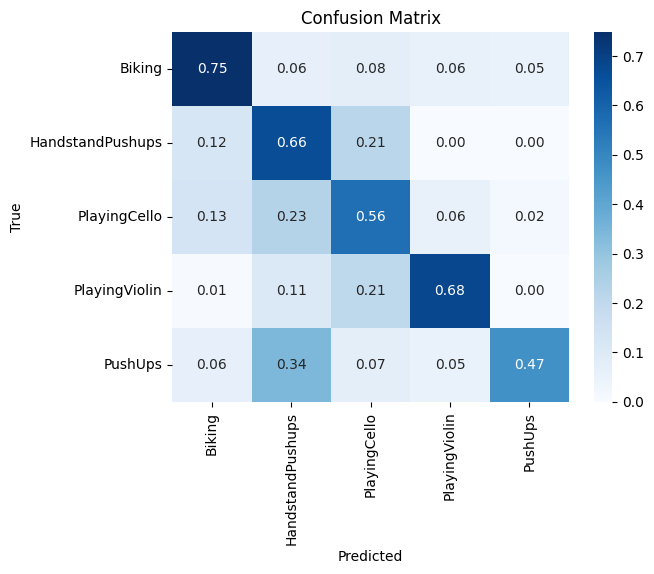

In [54]:
def measure_distance(fd1, fd2):
    return np.linalg.norm(fd1 - fd2)

def classify_frame_hog(fd, class_hog_averages):
    min_distance = float('inf')
    predicted_class = None
    for class_name, average_fd in class_hog_averages.items():
        distance = measure_distance(fd, average_fd)
        if distance < min_distance:
            min_distance = distance
            predicted_class = class_name
    return predicted_class

## Evaluation: cmopute preicision, recall and f1 and create confusion matrix
def evaluate_classification(hog_test_features_dataset, class_hog_averages):
    y_true = []
    y_pred = []
    for class_name, features in hog_test_features_dataset.items():
        for fd, hog_image in features:
            predicted_class = classify_frame_hog(fd, class_hog_averages)
            y_true.append(class_name)
            y_pred.append(predicted_class)

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    ## plot normalized seaborn confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=CLASS_NAMES, normalize='true')
    cm = pd.DataFrame(confusion_matrix, index=CLASS_NAMES, columns=CLASS_NAMES)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_classification(hog_test_features_dataset, class_hog_averages_reference)


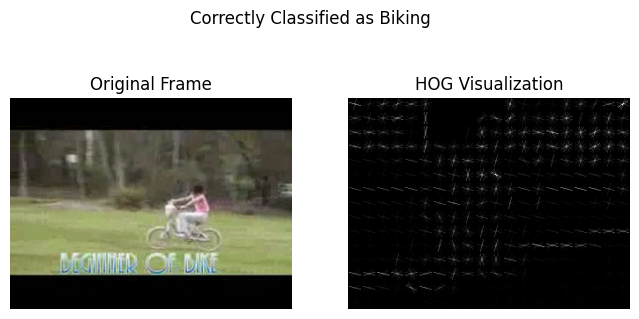

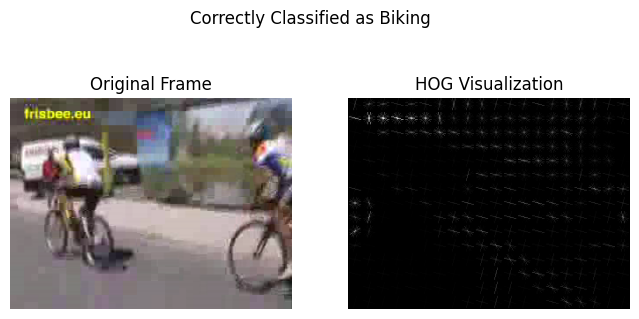

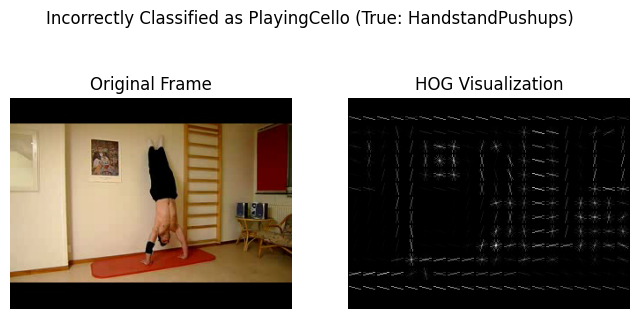

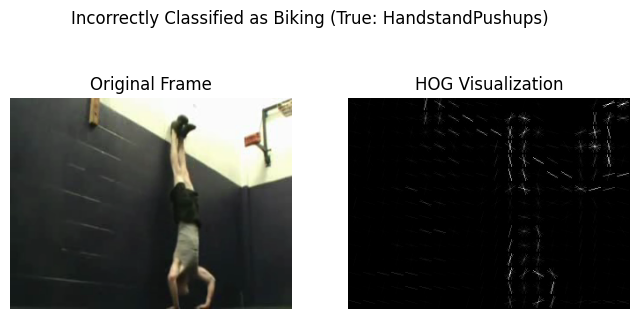

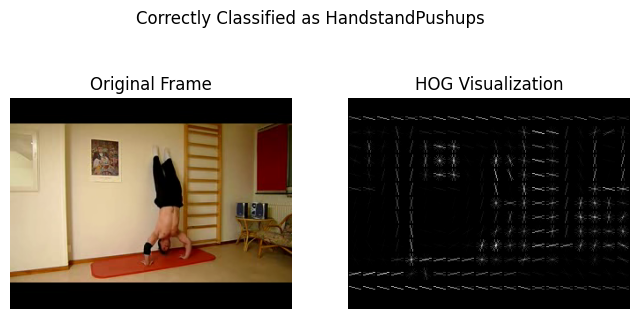

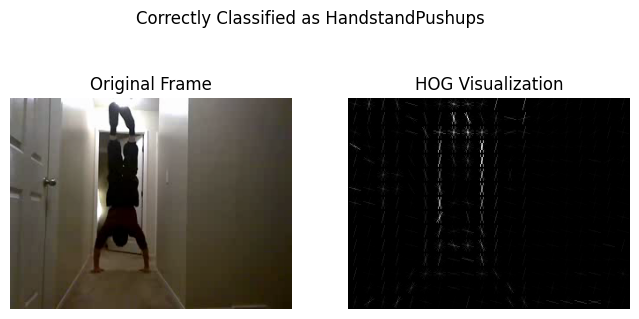

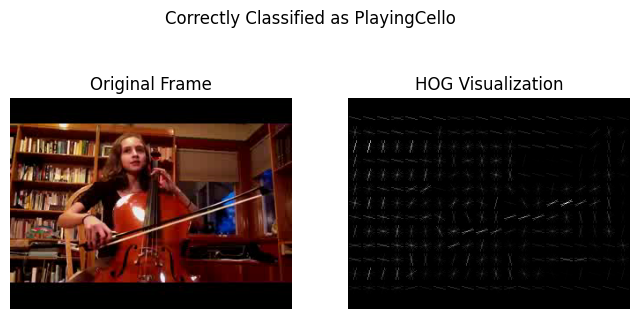

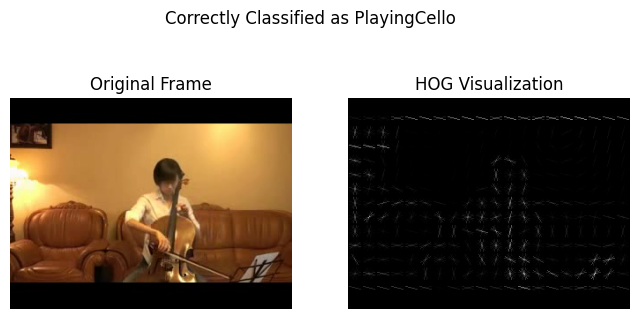

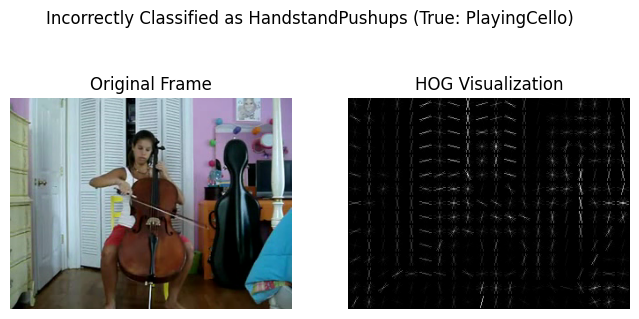

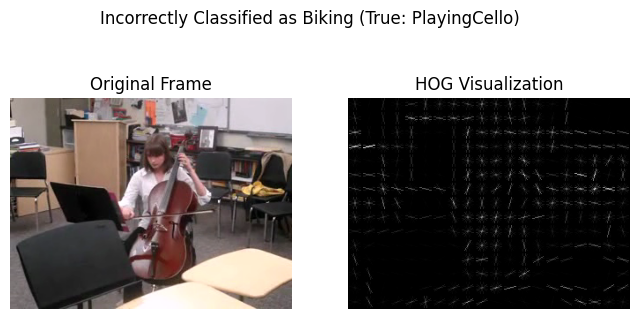

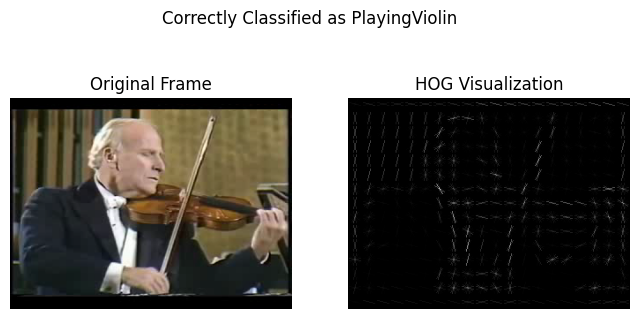

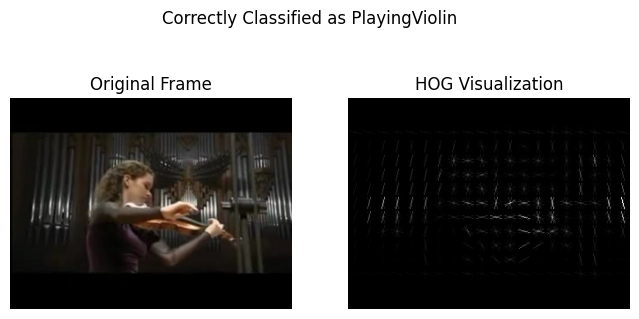

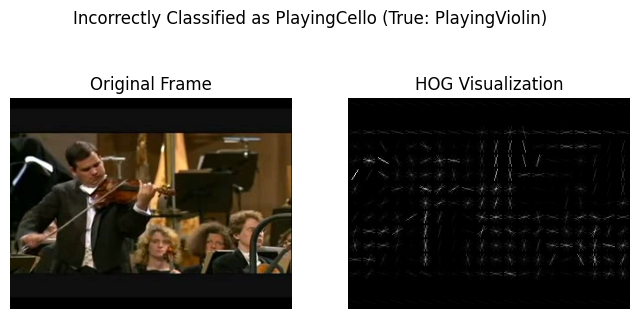

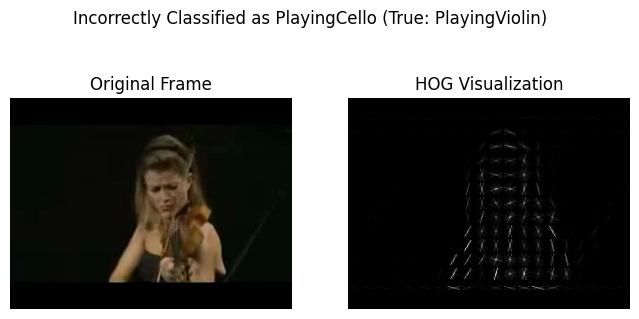

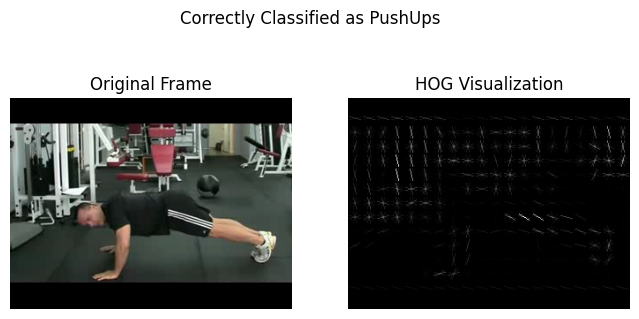

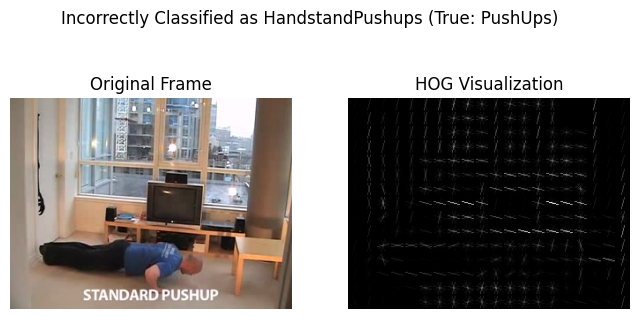

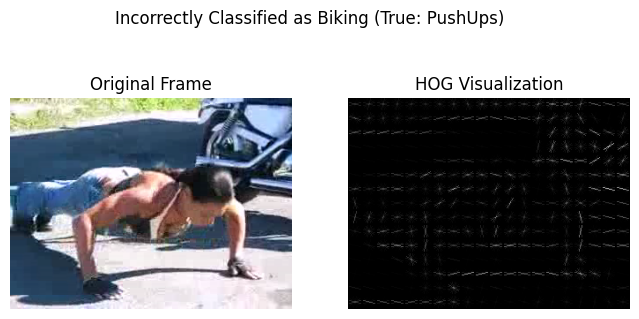

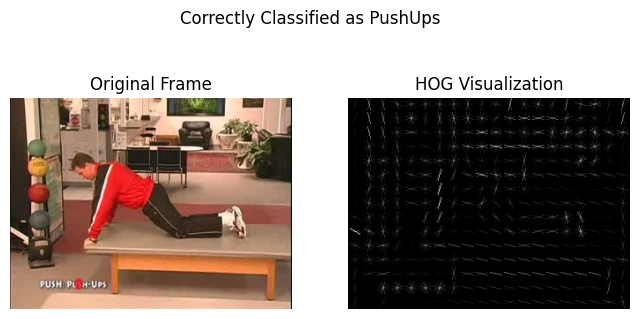

In [63]:
## show classification examples (images and HOG visualizations)
def show_image_classification_examples(frame_dataset, hog_features_dataset, class_hog_averages):
    examples_shown = 0
    ## for each class in the frame dictionnary dataset we take a frame, the equivalent feature in the hog_features_dataset and predict the classification, 
    # if it's correct we show it until we have 2 correct and 2 incorrect examples (for each class), we take frame far away from each other in the dataset to have variety
    for class_name in CLASS_NAMES:
        frames = frame_dataset[class_name]
        features = hog_features_dataset[class_name]
        correct_examples = 0
        incorrect_examples = 0
        for i in range(0, len(frames), max(1, len(frames)//10)):
            frame = frames[i]
            fd, hog_image = features[i]
            predicted_class = classify_frame_hog(fd, class_hog_averages)
            if predicted_class == class_name and correct_examples < 2:
                correct_examples += 1
                examples_shown += 1
                plt.figure(figsize=(8,4))
                plt.suptitle(f"Correctly Classified as {predicted_class}")
                plt.subplot(1,2,1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title("Original Frame")
                plt.axis('off')
                plt.subplot(1,2,2)
                plt.imshow(hog_image, cmap='gray')
                plt.title("HOG Visualization")
                plt.axis('off')
                plt.show()
            elif predicted_class != class_name and incorrect_examples < 2:
                incorrect_examples += 1
                examples_shown += 1
                plt.figure(figsize=(8,4))
                plt.suptitle(f"Incorrectly Classified as {predicted_class} (True: {class_name})")
                plt.subplot(1,2,1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title("Original Frame")
                plt.axis('off')
                plt.subplot(1,2,2)
                plt.imshow(hog_image, cmap='gray')
                plt.title("HOG Visualization")
                plt.axis('off')
                plt.show()
            if correct_examples >= 2 and incorrect_examples >= 2:
                break
        if examples_shown >= 4 * NUM_CLASSES:
            break

show_image_classification_examples(test_frame_dataset, hog_test_features_dataset, class_hog_averages_reference)

In [ ]:
## Compute classification using k-NN approach

